In [8]:
import pandas as pd
import numpy as np

In [9]:
# Sample data for income sheet and balance report

income_rows = []
for year, op_inc, opex, imp in [
    (2021, 21000, 8000, 3200),
    (2022, 23000, 8300, 2800),
    (2023, 25500, 8700, 2600),
    (2024, 29000, 9100, 2400),
]:
    net = op_inc - opex - imp  # Net profit = Operating income - Opex - Impairment
    income_rows.extend([
        {"year": year, "metric": "Net profit", "value": net},
        {"year": year, "metric": "Operating income", "value": op_inc},
        {"year": year, "metric": "Operating expenses", "value": opex},
        {"year": year, "metric": "Impairment charges", "value": imp},
    ])

income_df = pd.DataFrame(income_rows)

balance_data = [
    {"year": 2021, "metric": "Total assets", "value": 100000},
    {"year": 2022, "metric": "Total assets", "value": 105000},
    {"year": 2023, "metric": "Total assets", "value": 112000},
    {"year": 2024, "metric": "Total assets", "value": 118000},
    {"year": 2021, "metric": "Total equity", "value": 65000},
    {"year": 2022, "metric": "Total equity", "value": 67000},
    {"year": 2023, "metric": "Total equity", "value": 69000},
    {"year": 2024, "metric": "Total equity", "value": 71000},
    {"year": 2021, "metric": "Customer loans", "value": 45000},
    {"year": 2022, "metric": "Customer loans", "value": 47000},
    {"year": 2023, "metric": "Customer loans", "value": 49000},
    {"year": 2024, "metric": "Customer loans", "value": 52000},
]

balance_df = pd.DataFrame(balance_data)

print("Income statement sample:")
display(income_df.head(8))

print("\nBalance sheet sample:")
display(balance_df.head(8))

Income statement sample:


,year,metric,value
0,2021,Net profit,9800
1,2021,Operating income,21000
2,2021,Operating expenses,8000
3,2021,Impairment charges,3200
4,2022,Net profit,11900
5,2022,Operating income,23000
6,2022,Operating expenses,8300
7,2022,Impairment charges,2800



Balance sheet sample:


,year,metric,value
0,2021,Total assets,100000
1,2022,Total assets,105000
2,2023,Total assets,112000
3,2024,Total assets,118000
4,2021,Total equity,65000
5,2022,Total equity,67000
6,2023,Total equity,69000
7,2024,Total equity,71000


In [10]:
#Data query and calculation tools

def query_metric(df: pd.DataFrame, metric: str, years):
    """
    Filter a metric for a list of years from a long-format financial table.
    """
    years = list(years)
    return (
        df.query("metric == @metric and year in @years")
          .sort_values("year")
          .reset_index(drop=True)
    )


def compute_roe(net_profit: float, avg_equity: float):
    """
    Return on Equity = Net profit / Average equity.
    For demo, we approximate average equity as same-year equity.
    """
    if avg_equity == 0:
        return np.nan
    return net_profit / avg_equity


def compute_cagr(start_val: float, end_val: float, periods: int):
    """
    CAGR = (End / Start)^(1/periods) - 1
    """
    if start_val <= 0 or periods <= 0:
        return np.nan
    return (end_val / start_val) ** (1 / periods) - 1


In [11]:
#  Multi-hop ROE analysis

def analyze_roe_change(start_year: int, end_year: int):
    """
    Multi-step analysis:
    1) Retrieve Net profit & Total equity for range of years
    2) Compute ROE for each year
    3) Compute CAGR of Net profit over the period
    """
    years = list(range(start_year, end_year + 1))

    # Step 1: retrieve raw data
    profit = query_metric(income_df, "Net profit", years)
    equity = query_metric(balance_df, "Total equity", years)

    rows = []
    for year in years:
        p = float(profit.loc[profit["year"] == year, "value"].iloc[0])
        e = float(equity.loc[equity["year"] == year, "value"].iloc[0])

        # Step 2: compute ROE
        roe = compute_roe(p, e)
        rows.append({"year": year, "net_profit": p, "equity": e, "roe": roe})

    result_df = pd.DataFrame(rows)

    # Step 3: compute CAGR on net profit
    cagr = compute_cagr(
        result_df["net_profit"].iloc[0],
        result_df["net_profit"].iloc[-1],
        periods=len(years) - 1
    )

    return result_df, cagr


In [ ]:
# Scenario / what-if analysis tool

def simulate_opex_change(year: int, opex_change_pct: float):
    """
    Simulate impact of operating expense change on net profit and ROE for a given year.

    Steps:
    1) Retrieve operating income, opex, impairment, equity
    2) Compute base net profit & ROE
    3) Apply opex change (%)
    4) Compute new net profit & ROE
    """
    inc = query_metric(income_df, "Operating income", [year])["value"].iloc[0]
    opex = query_metric(income_df, "Operating expenses", [year])["value"].iloc[0]
    imp = query_metric(income_df, "Impairment charges", [year])["value"].iloc[0]
    equity = query_metric(balance_df, "Total equity", [year])["value"].iloc[0]

    base_np = inc - opex - imp
    base_roe = compute_roe(base_np, equity)

    new_opex = opex * (1 + opex_change_pct / 100.0)
    new_np = inc - new_opex - imp
    new_roe = compute_roe(new_np, equity)

    result = {
        "year": year,
            "opex_change_pct": opex_change_pct,
            "base_net_profit": base_np,
             "new_net_profit": new_np,
            "base_roe": base_roe,
                 "new_roe": new_roe,
    }
    return result


In [ ]:
# Simple multi-hop "agent"

def financial_agent(question: str):
    """
    Very simple rule-based agent to demonstrate:
    - reading a natural language question
    - decomposing into steps
    - calling data / calculation tools
    - printing a reasoning trace + final answer
    """

    q = question.lower()

    # Case 1: ROE change over a period
    if "roe" in q and ("change" in q or "improve" in q or "increase" in q):
        # For demo, we'll analyze 2021–2024
        start_year, end_year = 2021, 2024

        print("Agent: Detected a question about ROE change.\n")

        # Step 1: retrieve data
        print("Step 1: Retrieve Net profit and Total equity for each year.")
        roe_df, cagr = analyze_roe_change(start_year, end_year)
        display(roe_df)

        # Step 2: interpret results
        print("\nStep 2: Compute ROE trend and Net profit CAGR.")
        print(roe_df[["year", "roe"]])
        print(f"\nNet profit CAGR {start_year}–{end_year}: {cagr * 100:.2f}%")

        # Step 3: generate explanation
        start_roe = roe_df['roe'].iloc[0] * 100
        end_roe = roe_df['roe'].iloc[-1] * 100

        print("\nStep 3: Final explanation (user-facing):\n")
        print(
            f"Between {start_year} and {end_year}, ROE increased from "
            f"{start_roe:.1f}% to {end_roe:.1f}%. "
            "This reflects net profit growing faster than equity over the period. "
            "In a production system, this numeric view would be combined with management commentary from the MD&A to explain key drivers such as revenue growth, cost discipline, and changes in impairment charges."
        )

    # Case 2: Scenario / what-if on operating expenses
    elif "scenario" in q or "what if" in q or "operating expense" in q:
        year = 2024
        opex_change = 10  # +10% for demo; you could parse from question text

        print("Agent: Detected a scenario / what-if question.\n")
        print(f"Step 1: Simulate a {opex_change}% increase in operating expenses in {year}.")
        result = simulate_opex_change(year, opex_change)

        base_np = result["base_net_profit"]
        new_np = result["new_net_profit"]
        base_roe = result["base_roe"] * 100
        new_roe = result["new_roe"] * 100

        print("\nStep 2: Compare base vs scenario.")
        print(f"Base net profit  : {base_np:.1f} (AED mn)")
        print(f"New net profit   : {new_np:.1f} (AED mn)")
        print(f"Base ROE         : {base_roe:.2f}%")
        print(f"New ROE          : {new_roe:.2f}%")

        print("\nStep 3: Final explanation (user-facing):\n")
        print(
            f"In {year}, increasing operating expenses by {opex_change}% "
            f"would reduce net profit from {base_np:.1f} to {new_np:.1f} AED mn "
            f"and ROE from {base_roe:.2f}% to {new_roe:.2f}%. "
            "This demonstrates how the agent can combine financial statement data "
            "with scenario logic to answer what-if questions."
        )

    else:
        print("Agent: This demo currently handles:")
        print("- ROE change questions (mention 'ROE' and 'change' / 'improve' / 'increase').")
        print("- Scenario questions about operating expenses (mention 'scenario' or 'what if').")


In [14]:
#some example queries through the agent

print("=== Example 1: ROE change analysis ===")
financial_agent("Explain why ROE improved between 2021 and 2024.")

print("\n\n Example 2: Scenario / what-if analysis ===")
financial_agent("What if operating expenses increase? Show the impact scenario.")


=== Example 1: ROE change analysis ===
Agent: Detected a question about ROE change.

Step 1: Retrieve Net profit and Total equity for each year.


,year,net_profit,equity,roe
0,2021,9800.0,65000.0,0.150769
1,2022,11900.0,67000.0,0.177612
2,2023,14200.0,69000.0,0.205797
3,2024,17500.0,71000.0,0.246479



Step 2: Compute ROE trend and Net profit CAGR.
   year       roe
0  2021  0.150769
1  2022  0.177612
2  2023  0.205797
3  2024  0.246479

Net profit CAGR 2021–2024: 21.32%

Step 3: Final explanation (user-facing):

Between 2021 and 2024, ROE increased from 15.1% to 24.6%. This reflects net profit growing faster than equity over the period. In a production system, this numeric view would be combined with management commentary from the MD&A to explain key drivers such as revenue growth, cost discipline, and changes in impairment charges.


 Example 2: Scenario / what-if analysis ===
Agent: Detected a scenario / what-if question.

Step 1: Simulate a 10% increase in operating expenses in 2024.

Step 2: Compare base vs scenario.
Base net profit  : 17500.0 (AED mn)
New net profit   : 16590.0 (AED mn)
Base ROE         : 24.65%
New ROE          : 23.37%

Step 3: Final explanation (user-facing):

In 2024, increasing operating expenses by 10% would reduce net profit from 17500.0 to 16590.0 AED 

In [15]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")

In [16]:
def plot_trend(df, x_col, y_col, title, ylabel):
    """
    Simple line chart with markers.
    """
    plt.figure(figsize=(8, 4))
    plt.plot(df[x_col], df[y_col], marker="o", linewidth=2)
    plt.title(title, fontsize=14)
    plt.xlabel(x_col.capitalize())
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

In [17]:
def plot_scenario_comparison(base_np, new_np, base_roe, new_roe, year):
    """
    Bar chart comparing base vs scenario for Net Profit and ROE.
    """
    plt.figure(figsize=(10, 5))

    # Subplot 1: Net profit
    plt.subplot(1, 2, 1)
    plt.bar(["Base", "Scenario"], [base_np, new_np])
    plt.title(f"Net Profit Impact ({year})")
    plt.ylabel("AED mn")

    # Subplot 2: ROE
    plt.subplot(1, 2, 2)
    plt.bar(["Base", "Scenario"], [base_roe, new_roe])
    plt.title(f"ROE Impact ({year})")
    plt.ylabel("ROE %")

    plt.tight_layout()
    plt.show()

In [18]:
#Enhanced agent with charting ====

def financial_agent(question: str):
    q = question.lower()

    if "roe" in q and ("change" in q or "increase" in q or "improve" in q):
        start_year, end_year = 2021, 2024

        print("Agent: Detected ROE trend analysis.\n")

        # Step 1: Retrieve & compute
        print("Step 1: Fetching Net profit and Equity...")
        roe_df, cagr = analyze_roe_change(start_year, end_year)
        display(roe_df)

        # Step 2: Chart – ROE Trend
        print("\nStep 2: Plotting ROE trend...")
        plot_trend(roe_df, "year", "roe",
                   "ROE Trend Over Time",
                   "ROE (Net Profit / Equity)")

        # Step 3: Numeric summary
        start_roe = roe_df['roe'].iloc[0] * 100
        end_roe = roe_df['roe'].iloc[-1] * 100

        print("\nStep 3: Final Interpretation:\n")
        print(
            f"ROE increased from {start_roe:.1f}% in {start_year} "
            f"to {end_roe:.1f}% in {end_year}. "
            f"Net profit CAGR during this period is {cagr*100:.2f}%. "
            "The chart illustrates a steady improvement in profitability, "
            "driven by growing net income relative to equity."
        )

    # ------------------- SCENARIO ANALYSIS -------------------
    elif "scenario" in q or "what if" in q or "opex" in q or "operating expense" in q:
        year = 2024
        opex_change = 10

        print("Agent: Detected a scenario / what-if analysis.\n")

        # Step 1: Compute scenario
        print(f"Step 1: Simulating {opex_change}% opex increase for {year}...")
        result = simulate_opex_change(year, opex_change)

        base_np = result["base_net_profit"]
        new_np = result["new_net_profit"]
        base_roe = result["base_roe"] * 100
        new_roe = result["new_roe"] * 100

        print("\nComputed values:")
        print(f"Base NP    : {base_np:.1f}")
        print(f"Scenario NP: {new_np:.1f}")
        print(f"Base ROE   : {base_roe:.2f}%")
        print(f"New ROE    : {new_roe:.2f}%")

        # Step 2: Charts
        print("\nStep 2: Visualizing scenario impact...")
        plot_scenario_comparison(base_np, new_np, base_roe, new_roe, year)

        # Step 3: Explanation
        print("\nStep 3: Final Explanation:\n")
        print(
            f"In {year}, a {opex_change}% increase in operating expenses "
            f"reduces net profit from {base_np:.1f} to {new_np:.1f} AED mn "
            f"and ROE from {base_roe:.2f}% to {new_roe:.2f}%. "
            "The bars clearly show how cost inflation eats into profitability."
        )

    # ------------------- Unsupported -------------------
    else:
        print("Agent: Supported queries:")
        print(" - ROE change analysis (mention ROE + change/increase/improve)")
        print(" - Scenario analysis (mention scenario / what-if / opex)")

=== ROE Trend Example ===
Agent: Detected ROE trend analysis.

Step 1: Fetching Net profit and Equity...


,year,net_profit,equity,roe
0,2021,9800.0,65000.0,0.150769
1,2022,11900.0,67000.0,0.177612
2,2023,14200.0,69000.0,0.205797
3,2024,17500.0,71000.0,0.246479



Step 2: Plotting ROE trend...


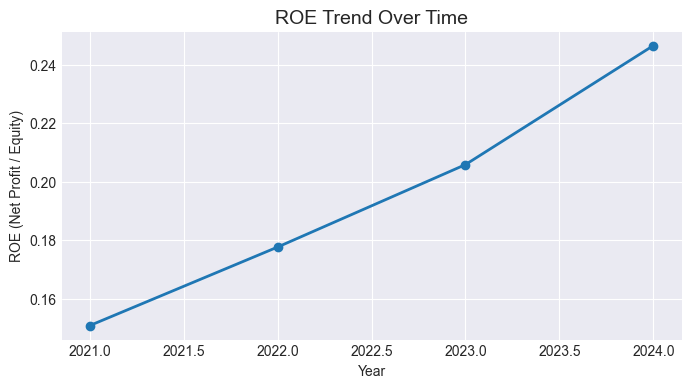


Step 3: Final Interpretation:

ROE increased from 15.1% in 2021 to 24.6% in 2024. Net profit CAGR during this period is 21.32%. The chart illustrates a steady improvement in profitability, driven by growing net income relative to equity.


=== Scenario Impact Example ===
Agent: Detected a scenario / what-if analysis.

Step 1: Simulating 10% opex increase for 2024...

Computed values:
Base NP    : 17500.0
Scenario NP: 16590.0
Base ROE   : 24.65%
New ROE    : 23.37%

Step 2: Visualizing scenario impact...


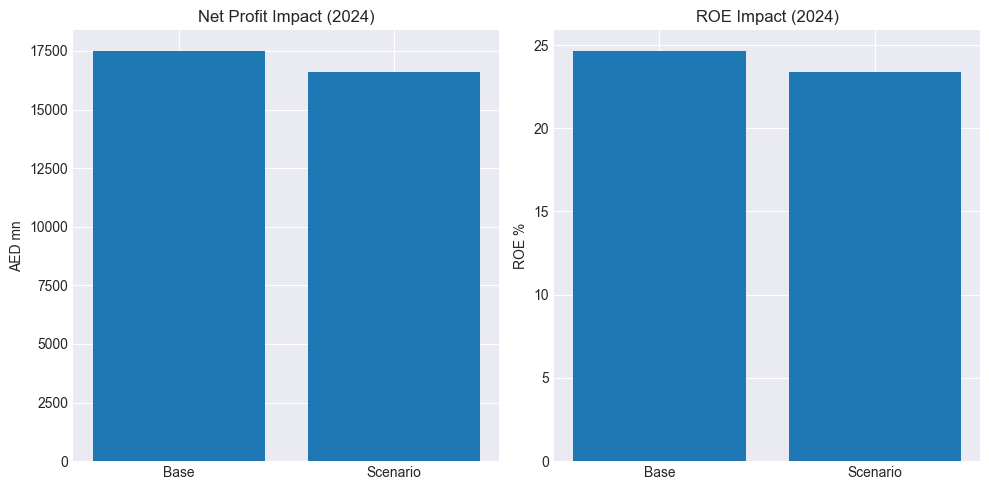


Step 3: Final Explanation:

In 2024, a 10% increase in operating expenses reduces net profit from 17500.0 to 16590.0 AED mn and ROE from 24.65% to 23.37%. The bars clearly show how cost inflation eats into profitability.


In [19]:
# Chart test

print("=== ROE Trend Example ===")
financial_agent("Show how ROE improved between 2021 and 2024 with chart")

print("\n\n=== Scenario Impact Example ===")
financial_agent("What if operating expenses increase? Show impact with chart")

In [20]:
#LLM-Style Natural Language Parser

import re


def llm_parse(question: str):
    """
    Simulated LLM-style parsing:
    - Classifies user intent
    - Extracts financial metrics
    - Extracts years
    - Detects scenario % change
    - Returns a clean JSON task plan
    """

    q = question.lower()

    intent = None

    # 1. Identify intent
    if "roe" in q and ("change" in q or "trend" in q or "increase" in q or "improve" in q):
        intent = "roe_trend"
    elif "scenario" in q or "what if" in q or "opex" in q or "expense" in q:
        intent = "scenario_analysis"
    else:
        intent = "unknown"

    # 2. Extract years mentioned
    years = re.findall(r"(20\d{2})", q)
    years = [int(y) for y in years]

    # Default: last 4 years if not specified
    if not years:
        years = [2021, 2022, 2023, 2024]

    # 3. Extract scenario percentage
    pct = re.findall(r"(\d+)%", q)
    pct = int(pct[0]) if pct else None

    # 4. Extract target metric
    metrics = []
    possible_metrics = ["net profit", "equity", "assets", "loans", "operating income",
                        "operating expenses", "impairment", "roe"]
    for m in possible_metrics:
        if m in q:
            metrics.append(m)

    return {
        "intent": intent,
        "years": years,
        "scenario_pct": pct,
        "metrics": metrics,
        "raw": question
    }

In [21]:
# Updated Agent to Use LLM Parser

def financial_agent(question):
    parsed = llm_parse(question)
    intent = parsed["intent"]

    print("🔍 Parsed Query:")
    display(parsed)

    # ---------------- ROE TREND ----------------
    if intent == "roe_trend":
        years = parsed["years"]
        start_year = min(years)
        end_year = max(years)

        print("\nAgent: Performing ROE Trend Analysis...\n")

        df, cagr = analyze_roe_change(start_year, end_year)
        display(df)

        plot_trend(df, "year", "roe", "ROE Trend Over Time", "ROE")

        print(
            f"\nROE improved from {df['roe'].iloc[0]*100:.2f}% to "
            f"{df['roe'].iloc[-1]*100:.2f}% from {start_year} to {end_year}."
        )
        return

    # ---------------- SCENARIO ----------------
    if intent == "scenario_analysis":
        year = parsed["years"][-1]
        pct = parsed["scenario_pct"] or 10

        print(f"Agent: Running Opex Scenario Analysis ({pct}% change)...\n")

        result = simulate_opex_change(year, pct)

        base_np = result["base_net_profit"]
        new_np = result["new_net_profit"]
        base_roe = result["base_roe"] * 100
        new_roe = result["new_roe"] * 100

        plot_scenario_comparison(base_np, new_np, base_roe, new_roe, year)

        print(
            f"\nA {pct}% increase in operating expenses reduces ROE "
            f"from {base_roe:.2f}% to {new_roe:.2f}% in {year}."
        )
        return

    # ---------------- UNKNOWN ----------------
    print("\n❓ Agent could not classify the query.")
    print("Try asking about 'ROE trend' or a 'scenario what-if'.")



=== TEST 1 ===
🔍 Parsed Query:


{'intent': 'roe_trend',
 'years': [2021, 2024],
 'scenario_pct': None,
 'metrics': ['roe'],
 'raw': 'Can you analyze how the ROE changed from 2021 to 2024?'}


Agent: Performing ROE Trend Analysis...



,year,net_profit,equity,roe
0,2021,9800.0,65000.0,0.150769
1,2022,11900.0,67000.0,0.177612
2,2023,14200.0,69000.0,0.205797
3,2024,17500.0,71000.0,0.246479


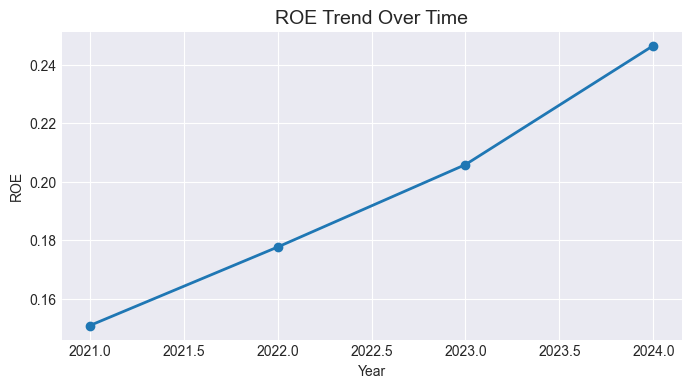


ROE improved from 15.08% to 24.65% from 2021 to 2024.


=== TEST 2 ===
🔍 Parsed Query:


{'intent': 'scenario_analysis',
 'years': [2023],
 'scenario_pct': 12,
 'metrics': ['operating expenses'],
 'raw': 'What if operating expenses increase by 12% in 2023? Show impact.'}

Agent: Running Opex Scenario Analysis (12% change)...



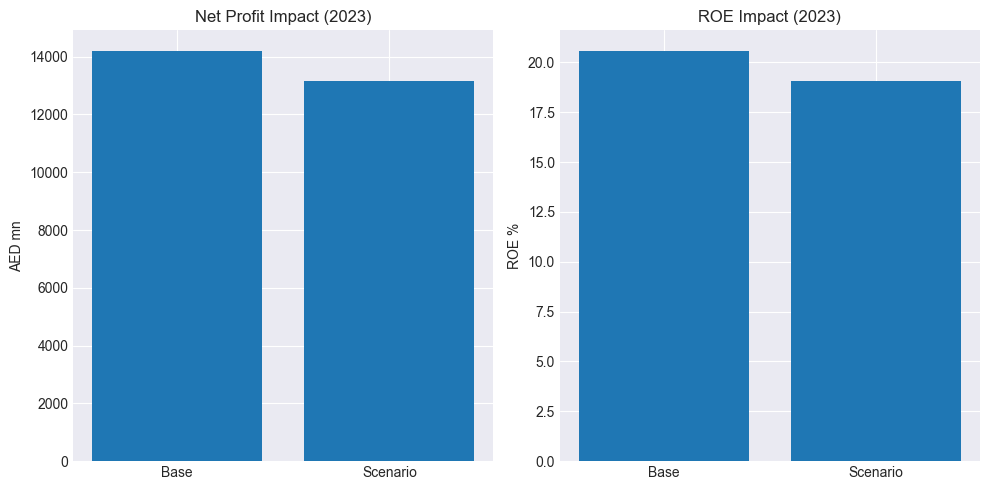


A 12% increase in operating expenses reduces ROE from 20.58% to 19.07% in 2023.


=== TEST 3 ===
🔍 Parsed Query:


{'intent': 'roe_trend',
 'years': [2021, 2022, 2023, 2024],
 'scenario_pct': None,
 'metrics': ['roe'],
 'raw': 'Give me ROE trend with chart for recent years.'}


Agent: Performing ROE Trend Analysis...



,year,net_profit,equity,roe
0,2021,9800.0,65000.0,0.150769
1,2022,11900.0,67000.0,0.177612
2,2023,14200.0,69000.0,0.205797
3,2024,17500.0,71000.0,0.246479


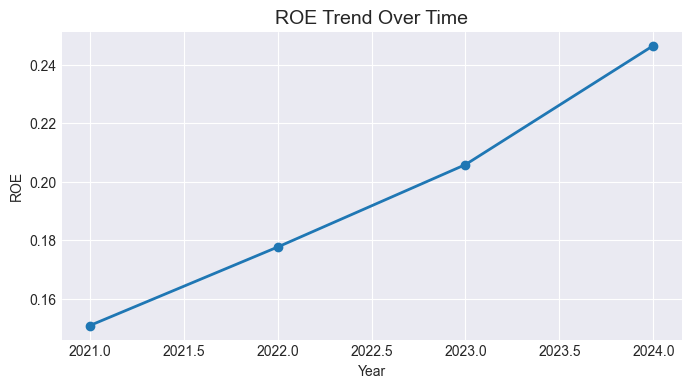


ROE improved from 15.08% to 24.65% from 2021 to 2024.


In [22]:
print("\n=== TEST 1 ===")
financial_agent("Can you analyze how the ROE changed from 2021 to 2024?")

print("\n\n=== TEST 2 ===")
financial_agent("What if operating expenses increase by 12% in 2023? Show impact.")

print("\n\n=== TEST 3 ===")
financial_agent("Give me ROE trend with chart for recent years.")
